## Spotify Review Sentiment Classifier
In this project we will perform sentiment analysis on Spotify App Reviews Using Deep Leanrning

### `Index`
* Library Imports
* Loading Dataset
* Data Cleaning and EDA
* Data Preprocessing
* Building Models
* Prediction


## Library Imports

In [110]:
import numpy as np
import pandas as pd
import seaborn as sns 
import string
import matplotlib.pyplot as plt
from matplotlib import colors
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from wordcloud import WordCloud

# Preprocessing and evaluation

from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [113]:
import nltk
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\mrity\AppData\Roaming\nltk_data...


True

## Loading Dataset

In [7]:
df = pd.read_csv('reviews.csv')
df.head()

,Time_submitted,Review,Rating,Total_thumbsup,Reply
0,2022-07-09 15:00:00,"Great music service, the audio is high quality...",5,2,NaN
1,2022-07-09 14:21:22,Please ignore previous negative rating. This a...,5,1,NaN
2,2022-07-09 13:27:32,"This pop-up ""Get the best Spotify experience o...",4,0,NaN
3,2022-07-09 13:26:45,Really buggy and terrible to use as of recently,1,1,NaN
4,2022-07-09 13:20:49,Dear Spotify why do I get songs that I didn't ...,1,1,NaN


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61594 entries, 0 to 61593
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Time_submitted  61594 non-null  object
 1   Review          61594 non-null  object
 2   Rating          61594 non-null  int64 
 3   Total_thumbsup  61594 non-null  int64 
 4   Reply           216 non-null    object
dtypes: int64(2), object(3)
memory usage: 2.3+ MB


In [32]:
#set color for data visualization
sns.set(rc={"axes.facecolor":"#e6ffed","figure.facecolor":"#e6ffed", "grid.color":"#99e2b4",
            "axes.edgecolor":"#69F2E8", "axes.labelcolor":"#37C2B8", "xtick.color":"#05B1A4",
            "ytick.color":"#07C2B9"})

# ['#4a7c59', '#68b0ab', '#8fc0a9', '#c8d5b9', '#faf3dd']
palettes = ['#B0087B', '#4C4A90', '#8653BD', '#6A2AAF', '#5A08B0']
cmap = colors.ListedColormap(['#0EF5EA', '#52DADA', '#1EC0C0', '#09B8B8', '#0983B8'])

## Data Cleaning and EDA

#### `Reply Column`

In [19]:
# As we can see there are only 216 Not Null entries in the Reply Column so it is not of much use to us
print(f"Total NaN Values in the Reply Column :- {df['Reply'].isna().sum()}")
print(f"Total Not NaN Values in the Reply Column :- {(~df['Reply'].isna()).sum()}")


Total NaN Values in the Reply Column :- 61378
Total Not NaN Values in the Reply Column :- 216


c:\Users\mrity\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Rating of Replied Reviews')

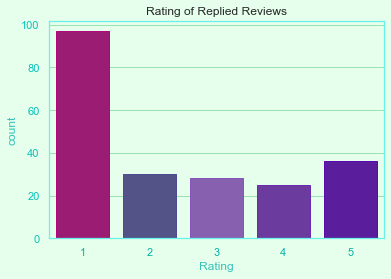

In [31]:
reply = df[~df['Reply'].isna()]

ax = sns.countplot(reply['Rating'], palette=palettes, edgecolor=palettes)
ax.set_title('Rating of Replied Reviews')

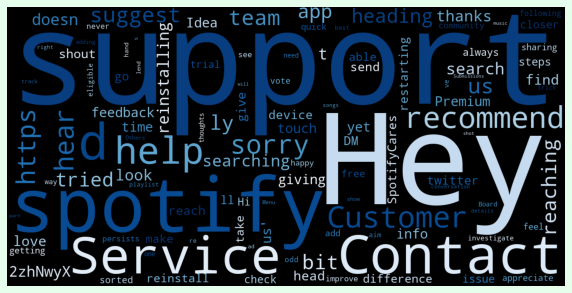

In [35]:
plt.figure(figsize=(10,10))
wc = WordCloud(max_words=1000, min_font_size=10,height=600, width=1200, collocations=False, background_color='#000000',colormap='Blues_r').generate(' '.join(reply['Reply']))

plt.axis('off')
plt.imshow(wc)

In [47]:
# We get a dictionary of all the words int he replies and their frquency
wc.process_text(''.join(reply['Reply']))

{'Hey': 194,
 'thanks': 55,
 'feedback': 41,
 'love': 44,
 'help': 109,
 'sorted': 18,
 'tried': 64,
 'reinstalling': 57,
 'yet': 39,
 'suggest': 77,
 'giving': 38,
 'go': 31,
 'doesn': 58,
 't': 58,
 'd': 113,
 'recommend': 106,
 'reaching': 67,
 'support': 204,
 'team': 77,
 'heading': 64,
 'spotify': 166,
 'searching': 61,
 'Contact': 118,
 "us'": 39,
 'report': 3,
 'clearing': 4,
 'app': 63,
 'cache': 5,
 'head': 36,
 'Home': 1,
 'settings': 3,
 'gear': 1,
 'icon': 1,
 'Storage': 1,
 'Delete': 1,
 'Customer': 104,
 'Service': 115,
 'search': 60,
 'us': 77,
 'always': 21,
 'add': 17,
 'replace': 6,
 'info': 40,
 'Suggested': 5,
 'songs': 9,
 'https': 80,
 'bit': 66,
 'ly': 66,
 '2zw3Xbj': 4,
 'Hi': 22,
 'James': 1,
 're': 11,
 'sorry': 82,
 'hear': 84,
 'time': 40,
 'give': 33,
 'shout': 33,
 'look': 54,
 'find': 43,
 'Premium': 40,
 'trial': 19,
 'shot': 8,
 'listen': 7,
 'music': 8,
 'demand': 1,
 'check': 22,
 'Cory': 1,
 'following': 15,
 'steps': 23,
 'site': 6,
 'reinstall': 2

In [48]:
# Now we will create a function to get the top words of a text

def top_words(text):
    word = pd.DataFrame(wc.process_text(''.join(text)).items()).sort_values(1, ascending=False)
    
    print('Top 5 words that appear most frequently:\n')
    for i in range(5):
        item = word.iloc[i]
        print(item[0] + '\t--> ' + str(item[1]))


In [50]:
# Now we will test our function
top_words(reply['Reply'])

Top 5 words that appear most frequently:

support	--> 204
Hey	--> 194
spotify	--> 166
Contact	--> 118
Service	--> 115


#### `Time Submitted`

In [58]:
df['Time_submitted'] = pd.to_datetime(df['Time_submitted'])
df['Date'] = df['Time_submitted'].apply(lambda x: x.date())

reviews_per_day  = df.groupby(df['Date']).count()['Review']
reviews_per_day = reviews_per_day.reset_index()
reviews_per_day['Month'] = reviews_per_day['Date'].apply(lambda x : x.month)
reviews_per_day.rename(columns={'Review':'Total_review'}, inplace=True)
reviews_per_day.head()

,Date,Total_review,Month
0,2022-01-01,46,1
1,2022-01-02,43,1
2,2022-01-03,66,1
3,2022-01-04,56,1
4,2022-01-05,64,1


Text(0.5, 1.0, 'Total Review per Day')

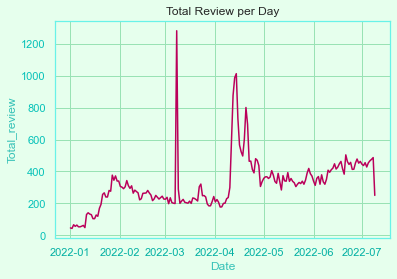

In [59]:
# Now we will plot the number of reviews per day using Seaborn's Lineplot
ax = sns.lineplot(data=reviews_per_day, x='Date', y='Total_review', color='#BA005A')
ax.set_title('Total Review per Day')

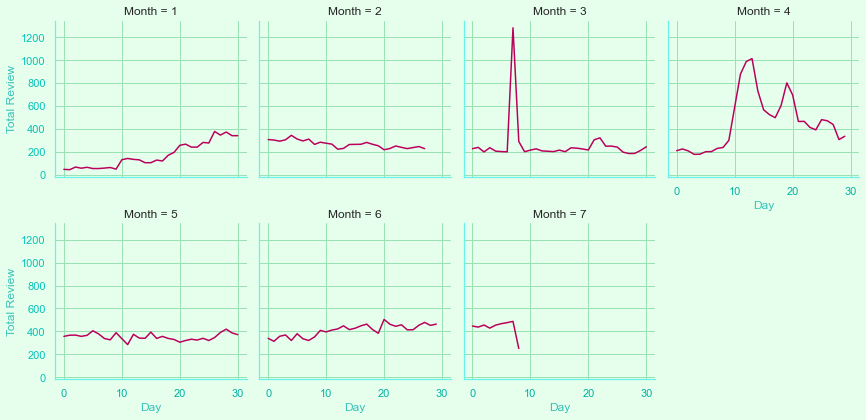

In [60]:
g = sns.FacetGrid(data=reviews_per_day, col='Month', col_wrap=4)
g.map(plt.plot, 'Total_review', color='#BA005A')
g.set_axis_labels(x_var='Day', y_var='Total Review')

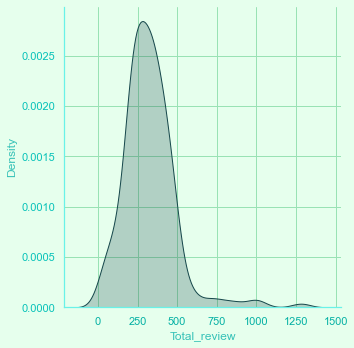

In [65]:
ax = sns.displot(data=reviews_per_day, x='Total_review', kind='kde', fill=True, color='#16474B')

#### `Rating`
We will change rating from an integer to a string

In [67]:
def transform_rating(score):
    if score > 3:
        return 'good'
    elif score == 3:
        return 'neutral'
    else:
        return 'bad'

Text(0.5, 1.0, 'Rating CountPlot')

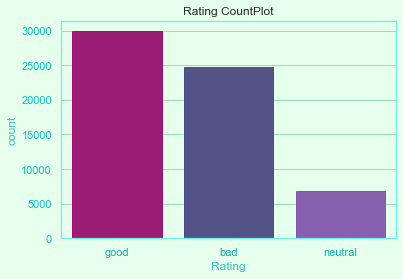

In [68]:
df['Rating'] = df['Rating'].apply(transform_rating)
ax = sns.countplot(data=df, x='Rating',palette=palettes,edgecolor=palettes)
ax.set_title('Rating CountPlot')

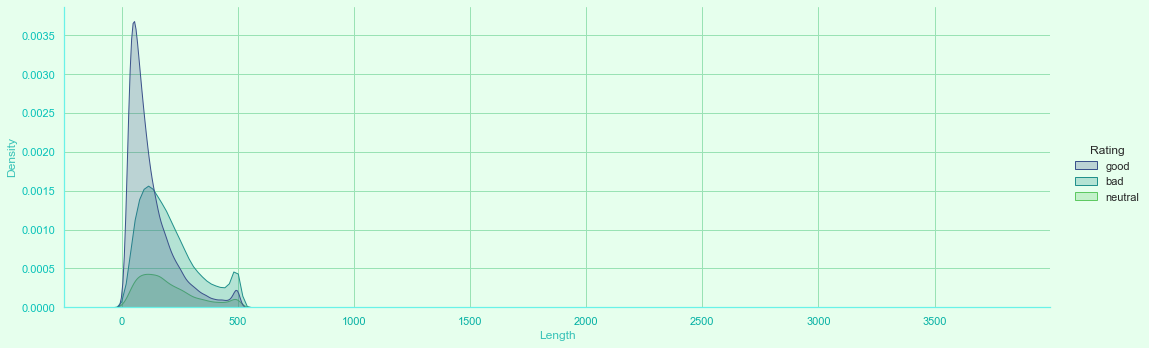

In [79]:
df['Length'] = df['Review'].apply(len)
ax = sns.displot(data=df, x='Length', hue='Rating', kind='kde', fill=True, aspect=3, palette='viridis')

Text(0.5, 1.0, 'Distribution of review Length\nfor Each Rating')

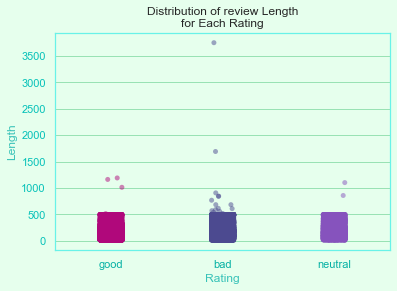

In [80]:
ax = sns.stripplot(data=df, x='Rating', y='Length', alpha=0.5, palette=palettes, edgecolor=palettes)
ax.set_title('Distribution of review Length\nfor Each Rating')

`We infer from the above plot group that majority of the reviews are of 500 words or less`

Text(0.5, 1.0, 'Average of review Length\nfor Each Rating')

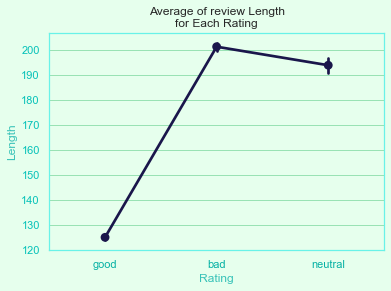

In [82]:
ax = sns.pointplot(data=df, x='Rating', y='Length', color='#1A164B')
ax.set_title('Average of review Length\nfor Each Rating')

` Average number words for each type of review is shown above`

#### `Total Thumbs Up`

In [89]:
# This review has the maximum thumbs up
max_thumb = df['Total_thumbsup'].max()
print(df[df['Total_thumbsup'] == max_thumb].iloc[0]['Review'],f'\nMax Thumbs up:- {max_thumb}')

The app is very good. I got to explore many new songs. However, I took out a star because of a few reasons. First:- It sometimes lags and won't show the music dialog box on your screen or in the app and for this I have to restart it. Second:- I cannot delete my history on phone. Third:- I cannot shuffle playlists or Albums. They have to play on the fixed sequence. Fourth:- I cannot see which song is going to play next if it's a radio and Fifth:- Sometimes the song stops and doesn't start radio 
Max Thumbs up:- 8195


Text(8, -0.2, 'Mean: 7.65')

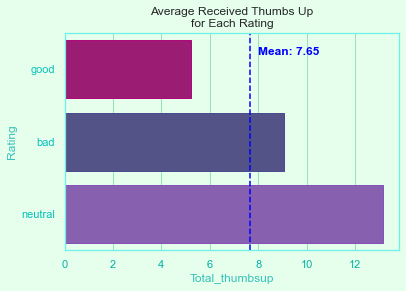

In [94]:
mean_thumb = df['Total_thumbsup'].mean()

ax = sns.barplot(data=df, y='Rating', x='Total_thumbsup', orient='h', ci=None, palette=palettes, edgecolor=palettes)
ax.set_title('Average Received Thumbs Up\nfor Each Rating')
plt.axvline(mean_thumb, color='blue', ls='--')
plt.text(x=8, y=-0.2, s='Mean: ' + str(round(mean_thumb, 2)), color='blue', weight='bold')

Text(0.5, 1.0, 'Distribution of Received Thumbs Up\nfor Each Rating')

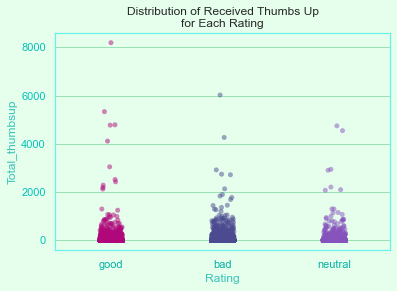

In [95]:
ax = sns.stripplot(data=df, x='Rating', y='Total_thumbsup', palette=palettes, edgecolor=palettes, alpha=0.5)
ax.set_title('Distribution of Received Thumbs Up\nfor Each Rating')

#### `Review In-Depth`

In [101]:
def get_wordcloud_and_top_words(df,rating_type):
    rating = df[df['Rating'] == rating_type]['Review']

    plt.figure(figsize=(10,10))
    wc = WordCloud(max_words=1000, min_font_size=10, height=600, width=1200, collocations=False,
                background_color='#000000', colormap='Blues_r').generate(' '.join(rating))

    plt.axis('off')
    plt.imshow(wc)
    
    top_words(rating)

##### `Good`

Top 5 words that appear most frequently:

app	--> 15681
music	--> 14881
song	--> 10608
Spotify	--> 8621
love	--> 6909


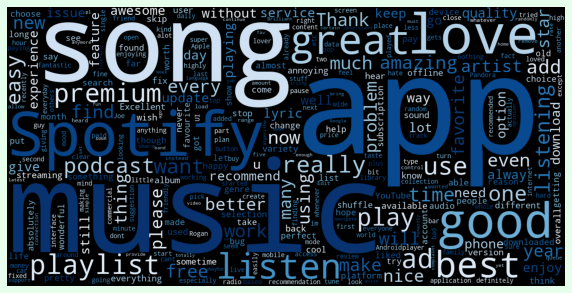

In [102]:
get_wordcloud_and_top_words(df,'good')

Top 5 words that appear most frequently:

song	--> 4993
app	--> 4125
music	--> 2322
play	--> 2032
Spotify	--> 1837


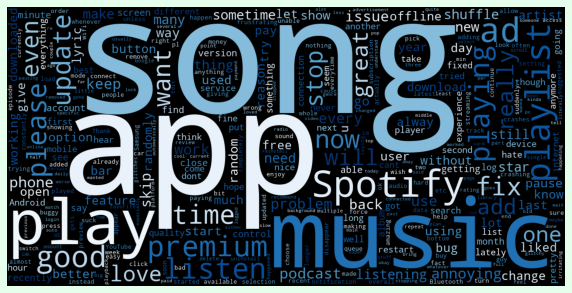

In [103]:
get_wordcloud_and_top_words(df,'neutral')

Top 5 words that appear most frequently:

song	--> 16766
app	--> 16445
play	--> 8867
music	--> 7745
Spotify	--> 7381


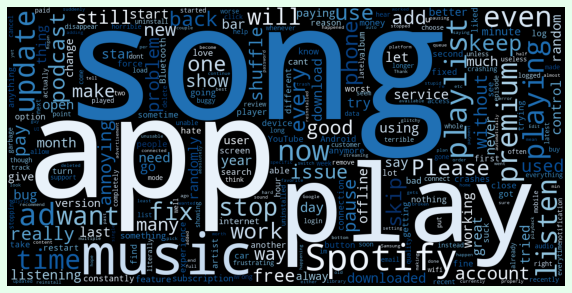

In [104]:
get_wordcloud_and_top_words(df,'bad')

### `Now we will Drop useless columns`

In [105]:
df_final = df[['Review', 'Rating', 'Length']]

## Data Preprocessing

In [106]:
# We will perform Lemmatization on the text get the base form of each word
def cleaning(text):
    #remove punctuations and uppercase
    clean_text = text.translate(str.maketrans('','',string.punctuation)).lower()
    
    #remove stopwords
    clean_text = [word for word in clean_text.split() if word not in stopwords.words('english')]
    
    #lemmatize the word
    sentence = []
    for word in clean_text:
        lemmatizer = WordNetLemmatizer()
        sentence.append(lemmatizer.lemmatize(word, 'v'))

    return ' '.join(sentence)

In [114]:
df['Review'] = df['Review'].apply(cleaning)

## Building Models

In [116]:
X_train, X_test, y_train, y_test = train_test_split(df['Review'], df['Rating'], test_size=0.2)

In [118]:
tokenizer = Tokenizer(num_words=50000, oov_token='<OOV>')

tokenizer.fit_on_texts(X_train)
# print(tokenizer.word_index)
total_word = len(tokenizer.word_index)
print('Total distinct words: {}'.format(total_word))

train_seq = tokenizer.texts_to_sequences(X_train)
train_padded = pad_sequences(train_seq)

test_seq = tokenizer.texts_to_sequences(X_test)
test_padded = pad_sequences(test_seq)

# One hot encoding the label
lb = LabelBinarizer()
train_labels = lb.fit_transform(y_train)
test_labels = lb.transform(y_test)

train_padded, test_padded

Total distinct words: 25585


(array([[    0,     0,     0, ...,   185,   684,     6],
        [    0,     0,     0, ...,     8,   528,  5223],
        [    0,     0,     0, ...,  9077,   806,   942],
        ...,
        [    0,     0,     0, ...,    30, 25584,    57],
        [    0,     0,     0, ...,    21,    26,    34],
        [    0,     0,     0, ...,    90,     3, 25585]]),
 array([[    0,     0,     0, ...,   117,   507,     1],
        [    0,     0,     0, ...,     9,   619,     2],
        [    0,     0,     0, ...,    97,     9,    41],
        ...,
        [    0,     0,     0, ...,   455,    42,   169],
        [    0,     0,     0, ...,    30, 12688,   230],
        [    0,     0,     0, ...,   263,   441,   825]]))

In [132]:
# We can get back the text from sequences using this function
tokenizer.sequences_to_texts([[987,232,123]])

['explore tell happen']

In [150]:
total_word

25585

In [153]:
model_lstm = tf.keras.models.Sequential([tf.keras.layers.Embedding(total_word+1, 8),
                                    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
                                    tf.keras.layers.Dropout(0.5),
                                    tf.keras.layers.Dense(16, activation='relu'),
                                    tf.keras.layers.Dropout(0.5),
                                    tf.keras.layers.Dense(3, activation='softmax')])

model_lstm.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 8)           204688    
                                                                 
 bidirectional_2 (Bidirectio  (None, 32)               3200      
 nal)                                                            
                                                                 
 dropout_5 (Dropout)         (None, 32)                0         
                                                                 
 dense_5 (Dense)             (None, 16)                528       
                                                                 
 dropout_6 (Dropout)         (None, 16)                0         
                                                                 
 dense_6 (Dense)             (None, 3)                 51        
                                                      

In [154]:
model_lstm.compile(optimizer=tf.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

model_lstm.fit(train_padded, train_labels, epochs=25, validation_data=(test_padded, test_labels))

Epoch 1/25
1540/1540 [==============================] - ETA: 0s - loss: 0.9952 - accuracy: 0.4700WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x0000027192782DC0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1540/1540 [==============================] - 170s 108ms/step - l

<AxesSubplot:>

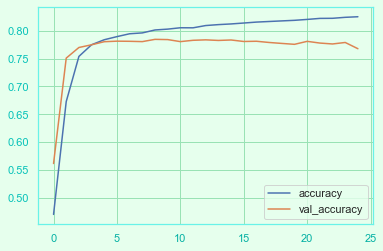

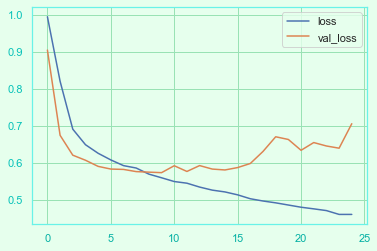

In [155]:
metrics_lstm = pd.DataFrame(model_lstm.history.history)
metrics_lstm[['accuracy', 'val_accuracy']].plot()
metrics_lstm[['loss', 'val_loss']].plot()

In [156]:
def lstm_prediction(text):
    clean_text = cleaning(text)
    seq = tokenizer.texts_to_sequences([clean_text])
    padded = pad_sequences(seq)

    pred = model_lstm.predict(padded)
    # Get the label name back
    result = lb.inverse_transform(pred)[0]
    
    return result

In [158]:
text1 = "There is a major bug in the app. I can't play my playlist since the last 2 days"
text2 = "Love this app! the interface is clean and pleasing to the eye"
print('LSTM\t: ', lstm_prediction(text2))

1/1 [==============================] - 1s 577ms/step
LSTM	:  good


In [159]:
model_lstm.save('Model_LSTM/')

INFO:tensorflow:Assets written to: Model_LSTM/assets


INFO:tensorflow:Assets written to: Model_LSTM/assets


In [135]:
model_gru = tf.keras.models.Sequential([tf.keras.layers.Embedding(total_word+1, 8),
                                    tf.keras.layers.GRU(8),
                                    tf.keras.layers.Dropout(0.5),
                                    tf.keras.layers.Dense(3, activation='softmax')])

model_gru.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 8)           204680    
                                                                 
 gru (GRU)                   (None, 8)                 432       
                                                                 
 dropout_2 (Dropout)         (None, 8)                 0         
                                                                 
 dense_2 (Dense)             (None, 3)                 27        
                                                                 
Total params: 205,139
Trainable params: 205,139
Non-trainable params: 0
_________________________________________________________________


In [146]:
model_gru.compile(optimizer=tf.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

model_gru.fit(train_padded, train_labels, epochs=25, validation_data=(test_padded, test_labels))

Epoch 1/25
  90/1540 [>.............................] - ETA: 1:42 - loss: 0.9117 - accuracy: 0.5767

InvalidArgumentError: Graph execution error:

Detected at node 'sequential_1/embedding_1/embedding_lookup' defined at (most recent call last):
    File "c:\Users\mrity\AppData\Local\Programs\Python\Python39\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\mrity\AppData\Local\Programs\Python\Python39\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "C:\Users\mrity\AppData\Roaming\Python\Python39\site-packages\ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "C:\Users\mrity\AppData\Roaming\Python\Python39\site-packages\traitlets\config\application.py", line 845, in launch_instance
      app.start()
    File "C:\Users\mrity\AppData\Roaming\Python\Python39\site-packages\ipykernel\kernelapp.py", line 612, in start
      self.io_loop.start()
    File "C:\Users\mrity\AppData\Roaming\Python\Python39\site-packages\tornado\platform\asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\mrity\AppData\Local\Programs\Python\Python39\lib\asyncio\windows_events.py", line 316, in run_forever
      super().run_forever()
    File "c:\Users\mrity\AppData\Local\Programs\Python\Python39\lib\asyncio\base_events.py", line 596, in run_forever
      self._run_once()
    File "c:\Users\mrity\AppData\Local\Programs\Python\Python39\lib\asyncio\base_events.py", line 1890, in _run_once
      handle._run()
    File "c:\Users\mrity\AppData\Local\Programs\Python\Python39\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\mrity\AppData\Roaming\Python\Python39\site-packages\tornado\ioloop.py", line 688, in <lambda>
      lambda f: self._run_callback(functools.partial(callback, future))
    File "C:\Users\mrity\AppData\Roaming\Python\Python39\site-packages\tornado\ioloop.py", line 741, in _run_callback
      ret = callback()
    File "C:\Users\mrity\AppData\Roaming\Python\Python39\site-packages\tornado\gen.py", line 814, in inner
      self.ctx_run(self.run)
    File "C:\Users\mrity\AppData\Roaming\Python\Python39\site-packages\tornado\gen.py", line 775, in run
      yielded = self.gen.send(value)
    File "C:\Users\mrity\AppData\Roaming\Python\Python39\site-packages\ipykernel\kernelbase.py", line 358, in process_one
      yield gen.maybe_future(dispatch(*args))
    File "C:\Users\mrity\AppData\Roaming\Python\Python39\site-packages\tornado\gen.py", line 234, in wrapper
      yielded = ctx_run(next, result)
    File "C:\Users\mrity\AppData\Roaming\Python\Python39\site-packages\ipykernel\kernelbase.py", line 261, in dispatch_shell
      yield gen.maybe_future(handler(stream, idents, msg))
    File "C:\Users\mrity\AppData\Roaming\Python\Python39\site-packages\tornado\gen.py", line 234, in wrapper
      yielded = ctx_run(next, result)
    File "C:\Users\mrity\AppData\Roaming\Python\Python39\site-packages\ipykernel\kernelbase.py", line 536, in execute_request
      self.do_execute(
    File "C:\Users\mrity\AppData\Roaming\Python\Python39\site-packages\tornado\gen.py", line 234, in wrapper
      yielded = ctx_run(next, result)
    File "C:\Users\mrity\AppData\Roaming\Python\Python39\site-packages\ipykernel\ipkernel.py", line 302, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "C:\Users\mrity\AppData\Roaming\Python\Python39\site-packages\ipykernel\zmqshell.py", line 539, in run_cell
      return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
    File "C:\Users\mrity\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py", line 2894, in run_cell
      result = self._run_cell(
    File "C:\Users\mrity\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py", line 2940, in _run_cell
      return runner(coro)
    File "C:\Users\mrity\AppData\Roaming\Python\Python39\site-packages\IPython\core\async_helpers.py", line 68, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\mrity\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py", line 3165, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\mrity\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py", line 3357, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "C:\Users\mrity\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py", line 3437, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "<ipython-input-146-5c71e7c8de39>", line 3, in <module>
      model_gru.fit(train_padded, train_labels, epochs=25, validation_data=(test_padded, test_labels))
    File "c:\Users\mrity\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\mrity\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 1409, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\Users\mrity\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 1051, in train_function
      return step_function(self, iterator)
    File "c:\Users\mrity\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 1040, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\mrity\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 1030, in run_step
      outputs = model.train_step(data)
    File "c:\Users\mrity\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 889, in train_step
      y_pred = self(x, training=True)
    File "c:\Users\mrity\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\mrity\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 490, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\Users\mrity\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\mrity\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\mrity\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\mrity\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\sequential.py", line 374, in call
      return super(Sequential, self).call(inputs, training=training, mask=mask)
    File "c:\Users\mrity\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\functional.py", line 458, in call
      return self._run_internal_graph(
    File "c:\Users\mrity\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\functional.py", line 596, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\Users\mrity\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\mrity\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\mrity\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\mrity\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\layers\core\embedding.py", line 199, in call
      out = tf.nn.embedding_lookup(self.embeddings, inputs)
Node: 'sequential_1/embedding_1/embedding_lookup'
indices[3,350] = 25585 is not in [0, 25585)
	 [[{{node sequential_1/embedding_1/embedding_lookup}}]] [Op:__inference_train_function_26059]

In [ ]:
metrics_gru = pd.DataFrame(model_gru.history.history)
metrics_gru[['accuracy', 'val_accuracy']].plot()
metrics_gru[['loss', 'val_loss']].plot()

In [147]:
test_labels.shape,train_labels.shape,train_padded.shape,test_padded.shape

((12319, 3), (49275, 3), (49275, 351), (12319, 78))

In [149]:
train_labels

array([[0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       ...,
       [0, 1, 0],
       [1, 0, 0],
       [0, 1, 0]])

In [160]:
import pickle

# saving
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('lemmatizer.pickle', 'wb') as handle:
    pickle.dump(lb, handle, protocol=pickle.HIGHEST_PROTOCOL)
